/apps/tensorflow/2.15/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'reg_lambda': 0.1, 'reg_alpha': 0.4, 'n_estimators': 240, 'max_depth': 4, 'eta': 0.03}


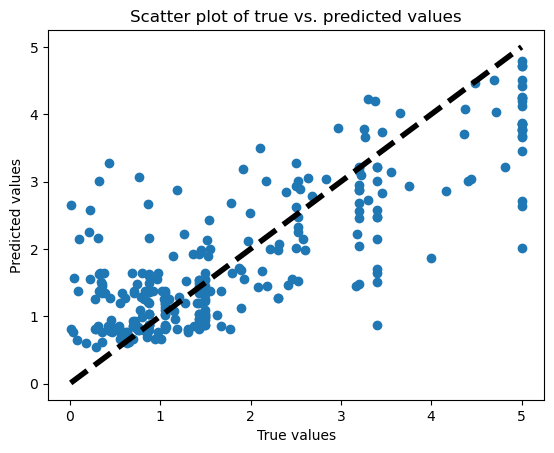

Training set:
R2: 0.7922951587102598
NSE: 0.7922951587102598
RMSE: 0.6332001903454726
MAE: 0.46489218467237015

Testing set:
R2: 0.6495131534783154
NSE: 0.6495131534783153
RMSE: 0.8431878541578702
MAE: 0.6154425011071446


In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from pprint import pprint
from sklearn import preprocessing
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Load and preprocess the dataset
data = pd.read_csv('VIS1S2PMETmSC.csv')

# Remove missing values
data = data.dropna() 
data['ET_wb'] = data['ET_wb'].astype(float)
#data_filted = data[(data['DSSAT_LAI'] >= 0.1) & (data['SM'] <= 0.35)]

X = data.iloc[:, [8,15]].values

#Perform scaling on the input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

y = data.iloc[:, 19].values 
y = y.reshape(-1, 1)
y = np.ravel(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=43)

hyperparameter_grid={'n_estimators':[240],
                     'max_depth':[4],
                     'eta':[0.03],
                     'reg_alpha': [0.4],
                     'reg_lambda': [0.1]}

random_cv=RandomizedSearchCV(XGBRegressor(), param_distributions=hyperparameter_grid,cv=5,n_iter=15,
                           scoring='neg_root_mean_squared_error',n_jobs=-1)
random_cv.fit(X_train,y_train)
print(random_cv.best_params_)

best_pipe=random_cv.best_estimator_

y_pred = best_pipe.predict(X_test)

T4SCSM1_XGB= pd.DataFrame({'Measured': y_test.flatten(), 'Estimated': y_pred.flatten()})

# Save the DataFrame to a file
T4SCSM1_XGB.to_csv('SCSM12_XGB.csv', index=False)

plt.scatter(y_test, y_pred)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Scatter plot of true vs. predicted values')

# add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# show the plot
plt.show()  

y_train_pred = best_pipe.predict(X_train)
y_train = y_train.reshape(-1)
y_train_pred= y_train_pred.reshape(-1)
mean_y_train = y_train.mean()
y_train_mean = np.repeat(y_train.mean(), y_train.shape[0])

train_r2 = r2_score(y_train, y_train_pred)
train_nse = 1 - mean_squared_error(y_train, y_train_pred)/mean_squared_error(y_train, y_train_mean)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_mae = mean_absolute_error(y_train, y_train_pred)

print("Training set:")
print("R2:", train_r2)
print("NSE:", train_nse)
print("RMSE:", train_rmse)
print("MAE:", train_mae)
print()

metricstrain = [
    {'Metric': 'RMSE', 'Value': train_r2},
    {'Metric': 'R2', 'Value': train_nse},
    {'Metric': 'NSE', 'Value': train_rmse},
    {'Metric': 'MAE', 'Value': train_mae}
]

df = pd.DataFrame(metricstrain)
df.to_csv('XGB_SC_trainmetrics.csv', index=False)


y_test_pred = best_pipe.predict(X_test)
y_test = y_test.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)
mean_y_test = y_test.mean()
y_test_mean = np.repeat(y_test.mean(), y_test.shape[0])

test_r2 = r2_score(y_test, y_test_pred)
test_nse = 1 - mean_squared_error(y_test, y_test_pred)/mean_squared_error(y_test, y_test_mean)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Testing set:")
print("R2:", test_r2)
print("NSE:", test_nse)
print("RMSE:", test_rmse)
print("MAE:", test_mae)

metricstest = [
    {'Metric': 'RMSE', 'Value': test_r2},
    {'Metric': 'R2', 'Value': test_nse},
    {'Metric': 'NSE', 'Value': test_rmse},
    {'Metric': 'MAE', 'Value': test_mae}
]

df = pd.DataFrame(metricstest)
df.to_csv('XGB_SC_testmetrics.csv', index=False)